# SVHN - The Street View House Numbers (SVHN) 



**Обработка .mat файлов с дальнейшим преобразованием их в csv файлы.**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
cd /content/gdrive/'My Drive'/KURSACH

/content/gdrive/My Drive/KURSACH


In [0]:
home_dir = 'data/'

In [0]:
dataset_name = 'extra' #train, test

In [0]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [0]:
import os
import sys
import tarfile
import numpy as np
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython.display import display, Image, HTML
import h5py

%matplotlib inline

**DigitStructWrapper cоздает массив словарей, содержащий имя файла и bounding boxes для каждой цифры в изображении.** 

In [0]:
import h5py 
class DigitStructWrapper:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

    def get_name(self, n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

    def get_attribute(self, attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

    def get_bbox(self, n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.get_attribute(self.inf[bb]["height"])
        bbox['label'] = self.get_attribute(self.inf[bb]["label"])
        bbox['left'] = self.get_attribute(self.inf[bb]["left"])
        bbox['top'] = self.get_attribute(self.inf[bb]["top"])
        bbox['width'] = self.get_attribute(self.inf[bb]["width"])
        return bbox

    def get_item(self, n):
        s = self.get_bbox(n)
        s['name'] = self.get_name(n)
        return s

    def unpack(self):
        return [self.get_item(i) for i in range(len(self.digitStructName))]

    def unpack_all(self):
        pictDat = self.unpack()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = {'filename': pictDat[i]["name"]}
            figures = []
            for j in range(len(pictDat[i]['height'])):
                figure = {}
                figure['height'] = pictDat[i]['height'][j]
                figure['label'] = pictDat[i]['label'][j]
                figure['left'] = pictDat[i]['left'][j]
                figure['top'] = pictDat[i]['top'][j]
                figure['width'] = pictDat[i]['width'][j]
                figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result

**Извлекает файл c bounding boxes и возвращает словарь**

In [0]:
def get_bounding_boxes(start_path = '.'): 
    return DigitStructWrapper(start_path).unpack_all()
train_bbox = get_bounding_boxes('data/digitStruct_extra.mat')  

In [0]:
print(train_bbox[0])

{'filename': '1.png', 'boxes': [{'height': 56.0, 'label': 4.0, 'left': 24.0, 'top': 70.0, 'width': 38.0}, {'height': 56.0, 'label': 7.0, 'left': 55.0, 'top': 41.0, 'width': 36.0}, {'height': 56.0, 'label': 8.0, 'left': 79.0, 'top': 23.0, 'width': 47.0}]}


In [0]:
from PIL import Image, ImageDraw

def display_bounding_boxes(img, bounding_boxes):
    image = Image.open(img)
    draw = ImageDraw.Draw(image)
    
    for b in bounding_boxes:
        rectangle = [b['left'], b['top'], b['left'] + b['width'], b['top'] + b['height']]
        draw.rectangle(rectangle, outline="green") 
    return image
#image = 'data/train/1.png'
image = 'data/extra/1.png'
image_bounding_boxes = train_bbox[0]['boxes']
     
display_bounding_boxes(image, image_bounding_boxes)

In [0]:
def dict_to_dataframe(image_bounding_boxes, path):
    boxes = []
    for image in image_bounding_boxes:
        for bbox in image['boxes']:
            boxes.append({
                    'filename':image['filename'],
                    'label': bbox['label'],
                    'width': bbox['width'],
                    'height': bbox['height'],
                    'top': bbox['top'],
                    'left': bbox['left']})
    return pd.DataFrame(boxes)
bbox_file = 'data/bounding_boxes_extra.csv'

if not os.path.isfile(bbox_file):
      
    train_df = dict_to_dataframe(train_bbox, 'data/extra/')

    print("Training", train_df.shape)
    print('')

    df = train_df
    df.rename(columns={'left': 'x0', 'top': 'y0'}, inplace=True)

    df['x1'] = df['x0'] + df['width']
    df['y1'] = df['y0'] + df['height']

    aggregate = {'x0':'min',
                'y0':'min',
                'x1':'max',
                'y1':'max',
                'label':{
                    'labels': lambda x: list(x),
                    'num_digits': 'count'}}


    df = df.groupby('filename').agg(aggregate).reset_index()
    df.columns = [x[0] if i < 5 else x[1] for i, x in enumerate(df.columns.values)]

    df.head()
    df.to_csv(bbox_file, index=False)

else:
    df = pd.read_csv(bbox_file)

df.head()

Training (531131, 6)



/usr/local/lib/python3.6/dist-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,filename,x0,y0,x1,y1,labels,num_digits
0,1.png,24.0,23.0,126.0,126.0,"[4.0, 7.0, 8.0]",3
1,10.png,5.0,5.0,52.0,32.0,"[4.0, 4.0, 4.0]",3
2,100.png,3.0,1.0,46.0,30.0,"[5.0, 3.0, 5.0]",3
3,1000.png,9.0,7.0,36.0,40.0,"[2.0, 6.0]",2
4,10000.png,8.0,9.0,41.0,35.0,"[2.0, 10.0, 10.0]",3


In [0]:
df[1:5]

,filename,x0,y0,x1,y1,labels,num_digits
1,10.png,16.0,19.0,38.0,40.0,"[1.0, 6.0]",2
2,100.png,124.0,65.0,152.0,99.0,"[6.0, 1.0]",2
3,1000.png,210.0,59.0,245.0,87.0,"[2.0, 7.0]",2
4,10000.png,35.0,11.0,66.0,32.0,"[1.0, 4.0, 3.0]",3


In [0]:
from PIL import Image, ImageDraw         #ИСПРАВИТЬ

def display_bbox(image_path, bbox):
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    draw.rectangle([bbox['x0'], bbox['y0'], bbox['x1'], bbox['y1']], outline="blue")
    return image

image = 'data/train/1.png'
bbox = df[df.filename == image]

# Display image
display_bbox(image, bbox)

In [0]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


In [0]:
class TrainSVHN(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.samples = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.samples.iloc[idx, 0])
        image = io.imread(img_name)
        boxes = self.samples.iloc[idx, 1:5].values#as_matrix()
        length = self.samples.iloc[idx, 6]
        labels = self.samples.iloc[idx, 5]
        labels=labels.replace("[","").replace("]","")
        labels=labels.split(",")
        labels = np.asarray(labels)
        labels=labels.astype('float')
        labels = np.array(labels)
        labels = labels.astype(int)
        labels[labels==10] = 0
        labels = ''.join([str(i) for i in labels])
        boxes = boxes.astype('float').reshape(-1, 4)
        sample = {'image': image, 'boxes': boxes, 'length': length, 'labels': labels}

        if self.transform:
            sample = self.transform(sample)

        return sample
       
  
  

In [0]:
class TestSVHN(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.samples = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.samples.iloc[idx, 0])
        image = io.imread(img_name)
        boxes = self.samples.iloc[idx, 1:5].values#as_matrix()
        length = self.samples.iloc[idx, 6]
        labels = self.samples.iloc[idx, 5]
        labels=labels.replace("[","").replace("]","")
        labels=labels.split(",")
        labels = np.asarray(labels)
        labels=labels.astype('float')
        labels = np.array(labels)
        labels = labels.astype(int)
        labels[labels==10] = 0
        labels = ''.join([str(i) for i in labels])
        boxes = boxes.astype('float').reshape(-1, 4)
        sample = {'image': image, 'boxes': boxes, 'length': length, 'labels': labels}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [0]:
import matplotlib.patches as patches
def display_bbox(image, boxes, length, labels):
    fig, ax = plt.subplots(1)
    plt.imshow(image)
    print('Length:',length)
    print('True label:',labels)
    rect = patches.Rectangle((boxes[0][0],boxes[0][3]),boxes[0][2]-boxes[0][0],boxes[0][1]-boxes[0][3],edgecolor='g',facecolor='none',lw=3) 
    ax.add_patch(rect)
    ax.grid(False)
    plt.show()
    
    

In [0]:
train_dataset = TrainSVHN(csv_file='data/bounding_boxes_train.csv',
                                    root_dir='data/train/')




In [0]:
test_dataset = TestSVHN(csv_file='data/bounding_boxes_test.csv',
                                    root_dir='data/test/')


In [0]:
sample=train_dataset[70]

In [0]:
sample=test_dataset[70]

Length: 3
True label: 187


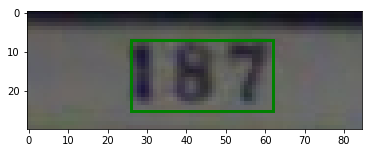

In [0]:
display_bbox(**sample)

In [0]:
print(sample['image'].shape, sample['boxes'].shape)

(30, 85, 3) (1, 4)


In [0]:
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, boxes = sample['image'], sample['boxes']
        length = sample['length']
        labels = sample['labels']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
               new_h, new_w = self.output_size, self.output_size
        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w), mode='constant',anti_aliasing=True)
        boxes = boxes * [new_w / w, new_h / h, new_w / w, new_h / h]

        return {'image': img, 'boxes': boxes,'length': length,'labels': labels}

Length: 3
True label: 187


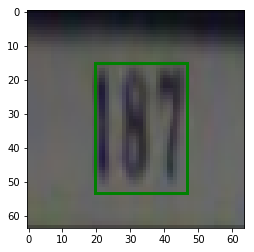

In [0]:
scale = Rescale(64)
tsfrm = scale
transformed_sample = tsfrm(sample)
display_bbox(**transformed_sample)

In [0]:
print(transformed_sample['image'].shape, transformed_sample['boxes'].shape)

(64, 64, 3) (1, 4)


In [0]:
print(transformed_sample['boxes'])

[[19.57647059 14.93333333 46.68235294 53.33333333]]


In [0]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, boxes = sample['image'], sample['boxes']
        length = sample['length']
        labels = sample['labels']
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'boxes': torch.from_numpy(boxes),'length': length,'labels': labels }

In [0]:
transformed_dataset_train = TrainSVHN(csv_file='data/bounding_boxes_train.csv',
                                    root_dir='data/train/',
                                           transform=transforms.Compose([
                                               Rescale(64),
                                               ToTensor()]))



In [0]:
transformed_dataset_test = TestSVHN(csv_file='data/bounding_boxes_test.csv',
                                    root_dir='data/test/',
                                           transform=transforms.Compose([
                                               Rescale(64),
                                               ToTensor()]))

In [0]:
tsample=transformed_dataset_test[70]

In [0]:
for i in range(len(transformed_dataset_test)):
    sample = transformed_dataset_test[i]

    print(i, sample['image'].size(), sample['boxes'].size())

    if i == 3:
        break

0 torch.Size([3, 64, 64]) torch.Size([1, 4])
1 torch.Size([3, 64, 64]) torch.Size([1, 4])
2 torch.Size([3, 64, 64]) torch.Size([1, 4])
3 torch.Size([3, 64, 64]) torch.Size([1, 4])


In [0]:
def display_bbox(image, boxes, length, labels):
    fig, ax = plt.subplots(1)
    plt.imshow(image)
    print('Length:',length)
    print('True label:',labels)
    rect = patches.Rectangle((boxes[0][0],boxes[0][3]),boxes[0][2]-boxes[0][0],boxes[0][1]-boxes[0][3],edgecolor='g',facecolor='none',lw=3) 
    ax.add_patch(rect)
    ax.grid(False)
    plt.show()

In [0]:
train_loader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)
import math

def show_boxes_batch(sample_batched):
    images_batch, boxes_batch = \
            sample_batched['image'], sample_batched['boxes']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    fig, ax = plt.subplots(1)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    print(im_size)
    for i in range(batch_size):
        rect = patches.Rectangle((boxes_batch[i][0][0] + i * im_size,boxes_batch[i][0][3] ),boxes_batch[i][0][2] - boxes_batch[i][0][0]+i*batch_size,boxes_batch[i][0][1] - boxes_batch[i][0][3],edgecolor='g',facecolor='none',lw=3) 
        ax.add_patch(rect)

        plt.title('Batch from dataloader')



0 torch.Size([4, 3, 64, 64]) torch.Size([4, 1, 4])
1 torch.Size([4, 3, 64, 64]) torch.Size([4, 1, 4])
2 torch.Size([4, 3, 64, 64]) torch.Size([4, 1, 4])
3 torch.Size([4, 3, 64, 64]) torch.Size([4, 1, 4])
64


<Figure size 432x288 with 0 Axes>

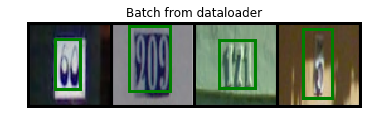

In [0]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['boxes'].size())
    if i_batch == 3:
        plt.figure()
        show_boxes_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [0]:
class RandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, boxes = sample['image'], sample['boxes']
        length = sample['length']
        labels = sample['labels']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        print(h)
        print(new_h)
        top = np.random.randint(0, h - new_h) 
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        boxes = boxes - [left, top, left, top]

        return {'image': image, 'boxes': boxes,'length': length,'labels': labels}

64
32
Length: 4
True label: 1000


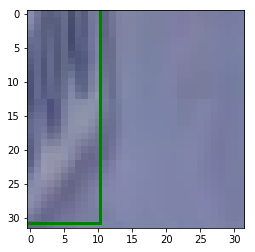

In [0]:
crop = RandomCrop(32)
tsfrm = crop
transformed_sample = tsfrm(transformed_sample)
display_bbox(**transformed_sample)

In [0]:
print(transformed_sample['image'].shape, transformed_sample['boxes'].shape)